Multicollinearity test

Numerical Columns for Analysis: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


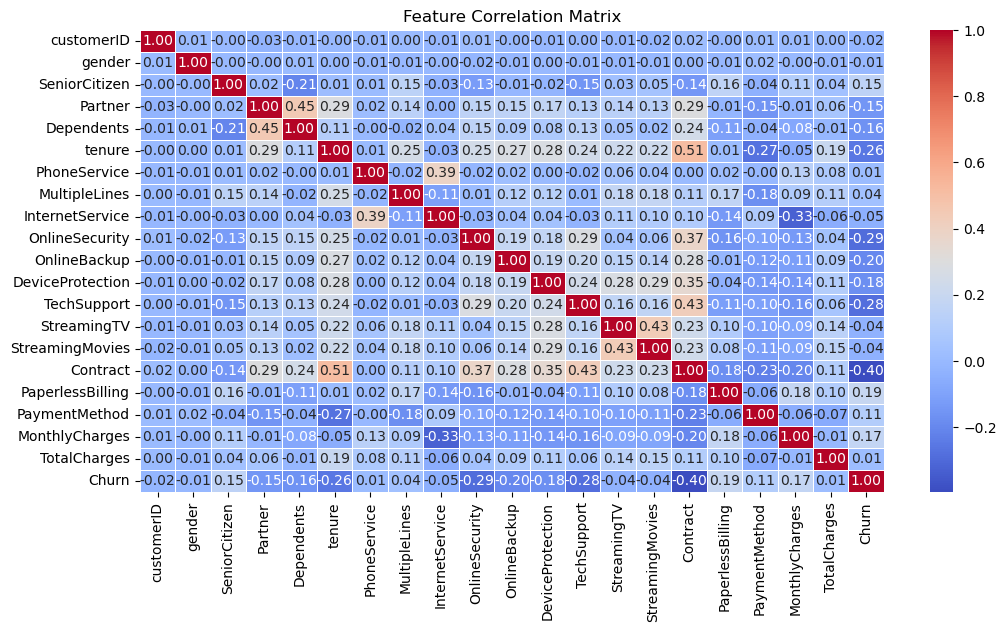

Variance Inflation Factor (VIF) Results:

             Feature  VIF Score
5       PhoneService  11.698805
4             tenure   4.872604
17    MonthlyCharges   4.563091
18      TotalCharges   4.154891
7    InternetService   3.559928
14          Contract   3.324245
13   StreamingMovies   3.018075
12       StreamingTV   2.987214
16     PaymentMethod   2.931001
15  PaperlessBilling   2.757391
2            Partner   2.750686
10  DeviceProtection   2.572337
11       TechSupport   2.396818
9       OnlineBackup   2.357910
6      MultipleLines   2.328782
8     OnlineSecurity   2.248401
3         Dependents   1.945455
0             gender   1.941394
19             Churn   1.721672
1      SeniorCitizen   1.351136


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Load the dataset
df = pd.read_csv("/home/bochere-lissa-belyne/Desktop/ML/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Step 2: Convert categorical features into numerical using Label Encoding
df = df.astype(str)  # Ensure categorical columns are treated as strings
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding to categorical variables
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Step 3: Identify numerical columns for correlation and VIF analysis
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

print("Numerical Columns for Analysis:", numerical_columns)

# Step 4: Compute Correlation Matrix
corr_matrix = df[numerical_columns].corr()

# Step 5: Visualize Correlation Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Step 6: Compute VIF
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF Score"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data.sort_values(by="VIF Score", ascending=False)

# Step 7: Drop 'Churn' (dependent variable) and compute VIF for independent variables
X = df[numerical_columns].drop(columns=["Churn"] and ["customerID"])  # Remove the target variable and unique ID
vif_results = calculate_vif(X)

# Step 8: Display VIF Scores
print("Variance Inflation Factor (VIF) Results:\n")
print(vif_results)






## Key Observations


### Strong Positive Correlations (Red Cells)

1. Contract vs. Tenure (0.51) → Customers with longer tenure tend to have longer contracts (logical, as long-term users prefer longer commitments).
2. TotalCharges vs. Tenure (0.40) → The longer a customer stays, the higher their TotalCharges (expected).
3. StreamingTV vs. StreamingMovies (0.43) → Customers who subscribe to StreamingTV often subscribe to StreamingMovies (these services are likely bundled).
4. TechSupport vs. OnlineSecurity (0.37) → Customers who opt for TechSupport also tend to choose OnlineSecurity.


### Strong Negative Correlations (Blue Cells)

1. Churn vs. Contract (-0.40) → Customers with longer contracts are less likely to churn. This suggests that offering longer contracts may improve retention.
2. Churn vs. Tenure (-0.26) → Customers with longer tenure are less likely to churn.
3. Churn vs. OnlineSecurity (-0.29) → Customers with OnlineSecurity services tend to stay longer, indicating security features may increase loyalty.


### Weak Correlations (Close to 0)

1. Many features, such as gender, Partner, PhoneService, have very weak correlations, meaning they don’t significantly impact other variables.
2. Churn vs. MonthlyCharges (0.17) → Weak positive correlation, meaning customers with higher monthly charges might churn slightly more often, but it’s not a strong predictor.



## Key Observations from VIF Results


1. PhoneService is 11.70 meaning High multicollinearity → Strongly correlated with other variables.
2. Tenure is 4.87 meaning Moderate multicollinearity. 
3. MonthlyCharges is 4.56 showing Some correlation.
4. TotalCharges is 4.15 showing Some correlation.
5. InternetService is 3.56. Acceptable, may still contribute unique information
6. Contract is 3.32. It is a good feature, likely influences Churn
7. StreamingMovies / StreamingTV is 3.0. Keep (related to InternetService, but unique)
8. PaperlessBilling & PaymentMethod is 2.9 showing Moderate correlation, likely useful for churn prediction
9. OnlineSecurity / OnlineBackup / TechSupport is 2.2 - 2.5. Acceptable, may impact Churn
10. Gender / SeniorCitizen is 1.3 and 1.9. No multicollinearity (Safe to keep)



#### Best Choice Based on the Data:

Regularization (Ridge/Lasso) is the Best Step

Why?

The correlation matrix suggests that some features have meaningful relationships with Churn—PCA would remove these relationships.
Regularization allows us to keep important features while reducing collinearity, making the model more interpretable.
Since we are predicting Churn (classification problem), Lasso regression can help select the most relevant variables.
If we use PCA, we lose feature interpretability, making it harder to explain model decisions.

Best Choice Based on the Data:
Lasso Regression (L1) is the Best Option
Why?

Lasso eliminates unimportant or redundant features → This is helpful because we have some features that may not contribute much (like PhoneService).
Since we have highly correlated features, Lasso will drop the least important ones, simplifying the model.
Lasso helps with feature selection, reducing overfitting and improving model interpretability (unlike Ridge, which keeps all features).

# Regularization

## Lasso regression

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

# 🔹 Load the dataset
df = pd.read_csv("/home/bochere-lissa-belyne/Desktop/ML/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 🔹 Drop customerID as it's not useful for prediction
df.drop(columns=['customerID'], inplace=True)

# 🔹 Convert categorical variables to numerical
df = pd.get_dummies(df, drop_first=True)

# 🔹 Separate Features (X) and Target (y)
X = df.drop(columns=['Churn_Yes'])  # Assuming 'Churn_Yes' is the target after encoding
y = df['Churn_Yes']

# 🔹 Standardize the features (important for Lasso)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 Split data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🔹 Apply Lasso Regression (alpha controls feature selection)
lasso = Lasso(alpha=0.001)  # Adjust alpha if needed
lasso.fit(X_train, y_train)

# 🔹 Get important features
lasso_coeffs = pd.Series(lasso.coef_, index=df.drop(columns=['Churn_Yes']).columns)


# 🔹 Print selected features
selected_features = lasso_coeffs[lasso_coeffs != 0].index.tolist()
print(f"🔹 Important Features Selected by Lasso: {selected_features}")


🔹 Important Features Selected by Lasso: ['SeniorCitizen', 'tenure', 'Partner_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'PaperlessBilling_Yes', 'PaymentMethod_Electronic check', 'TotalCharges_100.2', 'TotalCharges_100.25', 'TotalCharges_1001.2', 'TotalCharges_1004.75', 'TotalCharges_1007.9', 'TotalCharges_1008.7', 'TotalCharges_1009.25', 'TotalCharges_101.45', 'TotalCharges_101.65', 'TotalCharges_1011.8', 'TotalCharges_1013.35', 'TotalCharges_1014.25', 'TotalCharges_1017.35', 'TotalCharges_102.45', 'TotalCharges_102.5', 'TotalCharges_102.75', 'TotalCharges_1020.2', 'TotalCharges_1021.55', 'TotalCharges_1021.8', 'TotalCha

#### Key Insights from Selected Features
1. Demographic Factors

    SeniorCitizen: Whether the customer is a senior citizen is a key factor. Seniors may have different service needs or higher churn rates.
    Dependents_Yes: Customers with dependents may behave differently from those without, possibly affecting their loyalty.

2. Service-Related Features

    PhoneService_Yes & MultipleLines Variants: Indicates that having or not having a phone service or multiple lines affects the outcome.
    InternetService_Fiber optic & InternetService_No: The type of internet service is crucial. Fiber optic might have higher churn due to cost, while customers with no internet service may be more stable.
    OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies: These features are essential in predicting the outcome. If customers subscribe to these add-ons, they may be more engaged and less likely to churn.

3. Contract & Billing Factors

    Contract_One year & Contract_Two year: Contract length significantly affects customer behavior. Long-term contracts often lead to lower churn.
    PaperlessBilling_Yes: Customers opting for paperless billing may behave differently, possibly indicating a more digital-savvy customer base.
    PaymentMethod_Electronic check: Specific payment methods can indicate churn risk. Electronic checks might be linked to higher churn compared to auto-pay options.

4. Financial Factors (TotalCharges)

    A large number of specific TotalCharges values were selected, indicating that total billing amounts at different levels significantly impact the outcome.
    Customers with mid-to-high TotalCharges might have different churn behavior compared to low-charge customers.

#### Possible Business Implications

    Retention Strategies: Offer discounts or additional benefits to high-risk groups (e.g., senior citizens, electronic check users).
    Service Bundling: Encourage customers to use more add-ons (like Online Security or Tech Support) as they seem to reduce churn.
    Pricing Adjustments: Analyze high-churn TotalCharges brackets to adjust pricing or provide incentives.

🔹 Selected Features: ['SeniorCitizen', 'tenure', 'MonthlyCharges']


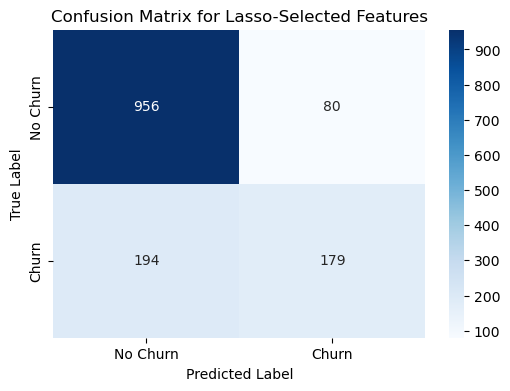


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.69      0.48      0.57       373

    accuracy                           0.81      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.81      0.79      1409



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Load the Dataset
df =pd.read_csv("/home/bochere-lissa-belyne/Desktop/ML/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Step 2: Handle Missing Values (Optional)
df = df.dropna()

# Step 3: Convert "Churn" Column to Numeric (Fixing the Error)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})  # ✅ Convert Yes/No to 1/0

# Step 4: Define Features (X) and Target (y)
X = df.drop(columns=["Churn"])  # Features
y = df["Churn"]  # Target variable

# Convert categorical features to numerical using One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Ensure X contains only numerical values
X = X.select_dtypes(include=[np.number])

# Step 5: Split Data into Training and Testing Sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Standardize the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Apply Lasso Regression for Feature Selection
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

# Step 8: Select Features with Non-Zero Coefficients
selected_features = X.columns[lasso.coef_ != 0]

if len(selected_features) == 0:
    raise ValueError("Lasso removed all features! Try reducing alpha value.")

print("🔹 Selected Features:", list(selected_features))

# Step 9: Keep Only Selected Features in Train & Test Sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Step 10: Train a Logistic Regression Model Using Selected Features
model = LogisticRegression()
model.fit(X_train_selected, y_train)

# Step 11: Make Predictions
y_pred = model.predict(X_test_selected)

# Step 12: Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Step 13: Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Lasso-Selected Features")
plt.show()

# Step 14: Print Classification Report
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
